__собираем статистики по объявлениям о продаже квартир__

_Evgeny S. Borisov <parser@mechanoid.su>_

In [1]:
!date

Пт 21 мар 2025 11:56:40 MSK


# загружаем данные

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd

pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
# df = pd.read_pickle('data/2024/df_flat.pkl')
df = pd.concat([ 
        # pd.read_pickle('data/2023/df_flat.pkl.gz').rename(columns={'adr':'address'}),
        pd.read_pickle('data/2024/df_flat.pkl.gz'),
        pd.read_pickle('data/2025/df_flat.pkl'), 
    ]).reset_index(drop=True)
df['dt'] = df['ts'].dt.date
display( len(df) )
cols = ['title','address','latitude','longitude','priceM','dt']
display( df.sample(3)[cols] )

142423

title  \
113761    1-к. апартаменты, 40,4 м², 6/8 эт.   
54970          2-к. квартира, 45 м², 1/2 эт.   
31664   1-комн. апартаменты, 14 м², 1/1 этаж   

                                                             address  \
113761                        судак,жилой комплекс бирюзовый квартал   
54970                            севастополь,улица маршала крылова,3   
31664   севастополь,р-н нахимовский,село орловка,шоссе качинское,33а   

         latitude  longitude  priceM          dt  
113761  44.852225  34.969465    6.72  2024-08-06  
54970   44.578703   33.43746    8.90  2024-11-26  
31664   44.735278  33.545707    2.20  2024-06-13

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142423 entries, 0 to 142422
Data columns (total 26 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   url            142423 non-null  object        
 1   place          142423 non-null  object        
 2   title          142423 non-null  object        
 3   subtitle       42935 non-null   object        
 4   price          142423 non-null  int64         
 5   address        142423 non-null  object        
 6   description    142423 non-null  object        
 7   ts             142423 non-null  datetime64[us]
 8   nrooms         142423 non-null  int64         
 9   floor          142423 non-null  int64         
 10  nfloors        142423 non-null  int64         
 11  area           142423 non-null  float64       
 12  is_studio      142423 non-null  bool          
 13  is_apartment   142423 non-null  bool          
 14  is_part        142423 non-null  bool          
 15  

In [5]:
dt_max_ = df['dt'].max()
dt_max_

datetime.date(2025, 3, 21)

In [6]:
# cols = [
#     'dt',    
#     'place', 
#     'title',
#     'subtitle',
#     'price', 
#     'priceM',
#     'address',
#     #'address_orig', 
#     'place_', 
#     # 'description',
#     'ts',
#     'nrooms',
#     'floor', 
#     'nfloors',
#     'area', 
#     'is_studio', 
#     'is_apartment',
#     'is_part', 
#     'is_auction', 
#     'is_openspace', 
#     'is_roof', 
#     'is_SNT',
#     'is_last_floor', 
#     'latitude', 
#     'longitude',
#     'url',
#     ]

# df[df['dt']==dt_max ][cols].drop_duplicates('url')['nrooms'].drop_duplicates()

In [7]:
# cols = ['title','address','latitude','longitude','priceM','dt','place','url']
# df[ (df['place']=='sevastopol') & (df['address'].str.match(r'.*Судак.*')) ][cols]

---

In [8]:
# df[ df['ts'].dt.date > pd.to_datetime('2024-01-01').date() ]

In [9]:
# df_ = pd.read_pickle('data/2023/data_flat.pkl').rename(columns={'adr':'address'})
# display( len(df_) )
# df_ = (
#         df_
#         .dropna(subset=['dt','url'])
#         .drop_duplicates(['dt','url'])
#         .drop(columns=['adr_orig','obj_name','avito_page','cian_page'])
#     )
# display( len(df_) )
# cols = ['title','address','latitude','longitude','priceM','dt','url']
# display( df_.sample(3)[cols] )

In [10]:
def address_filter(df):
    #           46.319437, 33.911048
    #
    # 45.402617, 32.455625 |  45.545301, 36.684702
    #
    #          44.320887, 33.917013

    df['latitude'] = pd.to_numeric( df['latitude'], errors='coerce' )
    df['longitude'] = pd.to_numeric( df['longitude'], errors='coerce' )

    df = df.query('(32.4<longitude<36.7) & (44.3<latitude<46.4)') 

#     df.loc[ df['url']=='https://avito.ru/2322251740', ['latitude','longitude']] = None

#     df.loc[ df['address']=='Севастополь,Чёрное море', ['latitude','longitude'] ] = None
#     df.loc[ df['address'].str.lower().str.match('чёрное море'), ['latitude','longitude'] ] = None 

#     df.loc[ df['address']=='квартал Старый Город', 'place'] = 'turkie'
#     df.loc[ df['address'].str.lower().str.match('анталья'), 'place' ] = 'turkie' 

#     df.loc[ df['address'].str.lower().str.match(r'.*бахчисарай.*'), 'place' ] = 'bahchisaray'
#     df.loc[ df['address'].str.lower().str.match(r'.*севастополь,.*'), 'place' ] = 'sevastopol'

#     df.loc[ df['address'].str.lower().str.match(r'.*мысовское.*'), 'place' ] = 'kerch'
#     df.loc[ df['address'].str.lower().str.match(r'.*алушта.*'), 'place' ] = 'alushta'
#     df.loc[ df['address'].str.lower().str.match(r'.*гурзуф.*'), 'place' ] = 'gurzuf'

#     df.loc[ df['address'].str.lower().str.match(r'.*с.лучистое.*'), 'place' ] = 'alushta'
#     df.loc[ df['address'].str.lower().str.match(r'.*снт солнечная долина.*'), 'place' ] = 'sudak'
#     df.loc[ df['address'].str.lower().str.match(r'.*пгт.новоозёрное.*'), 'place' ] = 'evpatoria'

#     df.loc[ df['address'].str.lower().str.match(r'.*с.мирное.*'), 'place' ] = 'simferopol'
#     df.loc[ df['address'].str.lower().str.match(r'.*тсн аэрофлот.*'), 'place' ] = 'simferopol'

#     df.loc[ df['address'].str.lower().str.match(r'.*семисот.*'), 'place' ] = 'kerch'

#     df.loc[ df['address'].str.lower().str.match(r'.*ялта.*') , 'place' ] = 'yalta'
#     df.loc[ df['address'].str.lower().str.match(r'.*феодосия.*') , 'place' ] = 'feodosia'
#     df.loc[ df['address'].str.lower().str.match(r'.*окуневка.*') , 'place' ] = 'tarkhankut'
#     df.loc[ df['address'].str.lower().str.match(r'.*заветное.*') , 'place' ] = 'kerch'
#     df.loc[ df['address'].str.lower().str.match(r'.*евпатория.*') , 'place' ] = 'evpatoria'
#     df.loc[ df['address'].str.lower().str.match(r'.*симферопольский район.*'), 'place' ] = 'simferopol'

#    df.loc[ df['address'].str.lower().str.match(r'.*c.симферопольский район.*'), 'place' ] = 'simferopol'

    df.loc[ df['address'].str.lower().str.match(r'.*судак,село радостное.*'), 'place' ] = 'st.krym'
    df = df.dropna(subset=['latitude','longitude'])
    
    return df

In [11]:
# df

In [12]:
# df['address']

In [13]:
display( len(df) )
df = address_filter(df)
# history_date = df_['dt'].max()
# df = pd.concat([df,df_])
display( len(df) )
# del df_

142423

141055

----

In [14]:
df['month'] = df['ts'].dt.to_period('M')
df['week'] = df['ts'].dt.to_period('W')

In [15]:
display( len(df) )
df = df.drop_duplicates(subset=['week','url']).reset_index(drop=True)
display( len(df) )

141055

125066

In [16]:
df['week'].max()

Period('2025-03-17/2025-03-23', 'W-SUN')

In [17]:
# display( len(df) )
# df = df.dropna(subset=['latitude','longitude'])
# display( len(df) )

----

In [18]:
display(len(df))
# выкидываем "ущербные" варианты 
df = df.query('~(is_studio|is_apartment|is_part|is_auction|is_openspace|is_SNT|is_roof)&(nrooms>0)&(nrooms<4)')
display(len(df))
df = df.query('priceM>1.') # выкидываем предожения с аномально низкой ценой
display(len(df))

125066

67756

67755

In [19]:
assert len(df)>1

In [20]:
# dt_max

In [21]:
gdf = gpd.GeoDataFrame( df, geometry = gpd.points_from_xy( df['longitude'], df['latitude']), crs='epsg:4326', )
# [['title','address','latitude','longitude','priceM']] 
display( gdf.sample(3)[cols])

title  \
108493    2-к. квартира, 60 м², 9/10 эт.   
39040   1-к. квартира, 37,1 м², 1/10 эт.   
111875   1-к. квартира, 43,7 м², 9/9 эт.   

                                                address  latitude  longitude  \
108493   севастополь,проспект генерала острякова,242ак2     44.56      33.53   
39040              севастополь,улица тараса шевченко,26     44.58      33.46   
111875  севастополь,проспект октябрьской революции,22/9     44.59      33.45   

        priceM          dt  
108493   10.30  2025-03-10  
39040     6.62  2024-09-24  
111875    7.50  2025-02-11

---

In [22]:
dt_max = df['dt'].max()
dt_min = df['dt'].min()
# display( dt_min,history_date,dt_max )
print( dt_min,' : ',dt_max )

2024-06-07  :  2025-03-21


In [23]:
# новые объявы сохранились после фильтрации данных
assert (dt_max==dt_max_)

In [24]:
# gdf_history = gdf.query(f'dt <= @history_date')
# gdf = gdf.query(f'dt > @history_date')

In [25]:
# display( len(gdf_history) )
display( len(gdf) )

67755

In [26]:
display( len(gdf) )
gdf = (
    gdf
    .query("place in ('sevastopol','sudak')")
    # .drop_duplicates(['dt','url'])
    .drop_duplicates(['url','week'])
    .reset_index(drop=True)
)
display( len(gdf) )

67755

67738

In [27]:
# новые объявы сохранились после конвертации данных
assert (gdf['dt'].max() == dt_max_)

In [28]:
# # display( gdf.columns )

# display( len(gdf) )
# gdf = gdf.drop_duplicates(['url','week'])
# display( len(gdf) )

In [29]:
# gdf.columns

In [30]:
# цена за квадратный метр (тыс.руб.)
gdf['price_area_K'] = (gdf['price']/gdf['area'])/1_000

# общая статистика

In [31]:
# gdf[['title','address','priceM','geometry']].sample(1024).explore()

In [32]:
gdf.query('place=="sevastopol"')[['title','address','priceM','geometry']].sample(1024).explore()

In [33]:
gdf.query('place=="sudak"')[['title','address','priceM','geometry']].explore()

In [34]:
# gdf_last[ gdf_last['address'].str.match(r'.*долина роз.*') ][['title','address','priceM','geometry','url']].explore()

---

In [35]:
percentiles=[.01,.05,.1,.25,.5,.75,.9,.95]
stat = (
        gdf
        .groupby(['place','nrooms','week'])
#         .groupby(['place','nrooms','month'])
        ['priceM'].describe(percentiles=percentiles)
    )
    
display( stat )

count  mean  std  min   1%   5%  10%  \
place      nrooms week                                                          
sevastopol 1      2024-06-03/2024-06-09 660.00  7.01 2.01 2.70 3.66 4.50 4.80   
                  2024-06-10/2024-06-16 960.00  7.11 1.95 2.70 3.88 4.50 4.90   
                  2024-06-17/2024-06-23 846.00  7.12 1.89 2.70 3.70 4.59 4.90   
                  2024-06-24/2024-06-30 664.00  7.15 1.88 2.70 3.66 4.56 4.92   
                  2024-07-08/2024-07-14 700.00  7.34 2.36 2.80 3.55 4.50 4.85   
...                                        ...   ...  ...  ...  ...  ...  ...   
sudak      3      2025-01-27/2025-02-02   5.00 11.82 6.67 5.50 5.65 6.24 6.98   
                  2025-02-10/2025-02-16  27.00 10.03 6.51 3.90 3.95 4.13 4.23   
                  2025-02-24/2025-03-02   3.00  7.83 2.02 5.50 5.57 5.85 6.20   
                  2025-03-10/2025-03-16   3.00  7.90 1.91 5.70 5.77 6.03 6.36   
                  2025-03-17/2025-03-23   5.00 12.21 6.47 7.60 7.63 7.74 7.88   

                                         25%  50%   75%   90%   95%   max  
place      nrooms week                                                     
sevastopol 1      2024-06-03/2024-06-09 5.50 6.85  7.95  9.49 10.70 18.99  
                  2024-06-10/2024-06-16 5.70 7.09  7.90  9.30 10.20 20.00  
                  2024-06-17/2024-06-23 5.76 7.08  8.00  9.25 10.20 20.00  
                  2024-06-24/2024-06-30 5.76 7.15  8.10  9.30 10.20 16.23  
                  2024-07-08/2024-07-14 5.70 7.25  8.21  9.80 11.28 19.71  
...                                      ...  ...   ...   ...   ...   ...  
sudak      3      2025-01-27/2025-02-02 9.20 9.40 12.00 18.61 20.81 23.01  
                  2025-02-10/2025-02-16 5.28 9.20  9.75 20.30 23.06 30.00  
                  2025-02-24/2025-03-02 7.25 9.00  9.00  9.00  9.00  9.00  
                  2025-03-10/2025-03-16 7.35 9.00  9.00  9.00  9.00  9.00  
                  2025-03-17/2025-03-23 8.30 9.00 13.00 19.09 21.12 23.16  

[227 rows x 13 columns]

In [36]:
import matplotlib.pyplot as plt

cols = ['1%','10%','25%','50%','75%']
sizes = stat.reset_index()['nrooms'].unique()

In [37]:
# # history_date

# place = 'sevastopol'

# fig, ax = plt.subplots(len(sizes),1,figsize=(11,4*len(sizes)), sharey=True )

# for i,s in enumerate(sizes): 
#     stat.loc[(place,s),cols].plot(title=f'цена на {s}к', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   
#     ax[i].set_yticks( np.arange(2, 16, step=1) )

# fig.suptitle(f'{place}, изменение цены на квартиры', fontsize=16)
# fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
# fig.tight_layout()

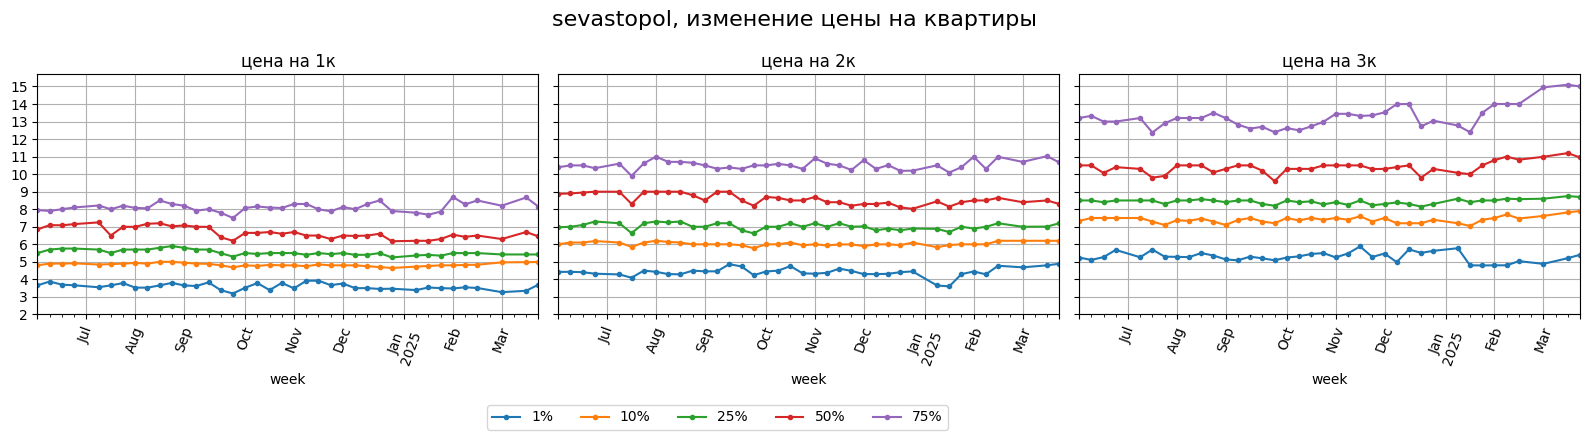

In [38]:
# history_date

place = 'sevastopol'

fig, ax = plt.subplots(1,len(sizes),figsize=(16,4), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(place,s),cols].plot(title=f'цена на {s}к', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   
    ax[i].set_yticks( np.arange(2, 16, step=1) )

fig.suptitle(f'{place}, изменение цены на квартиры', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

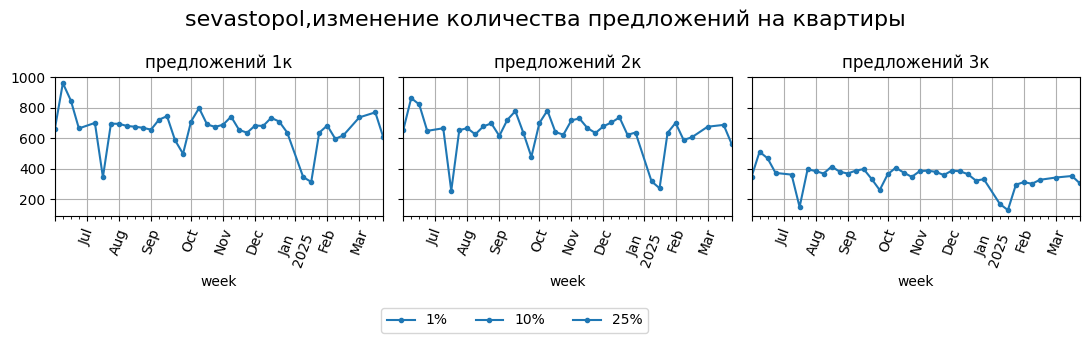

In [39]:
fig, ax = plt.subplots(1,len(sizes),figsize=(11,3), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(place,s),'count'].plot(title=f'предложений {s}к',grid=True,ax=ax[i],legend=False,rot=70,style='.-')
#     ax[i].set_yticks( np.arange(2, 16, step=1) )


fig.suptitle(f'{place},изменение количества предложений на квартиры', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

---

In [40]:
stat.loc['sudak'][['count']].describe(percentiles).T

count  mean   std  min   1%   5%  10%   25%   50%   75%   90%    95%  \
count 113.00 44.36 37.20 1.00 3.00 4.00 5.20 11.00 32.00 80.00 93.60 112.40   

         max  
count 134.00

In [41]:
display(len(stat.loc['sudak']))
stat_ = stat.loc['sudak'].query('count>25')
display(len(stat_))

113

64

In [42]:
# stat_

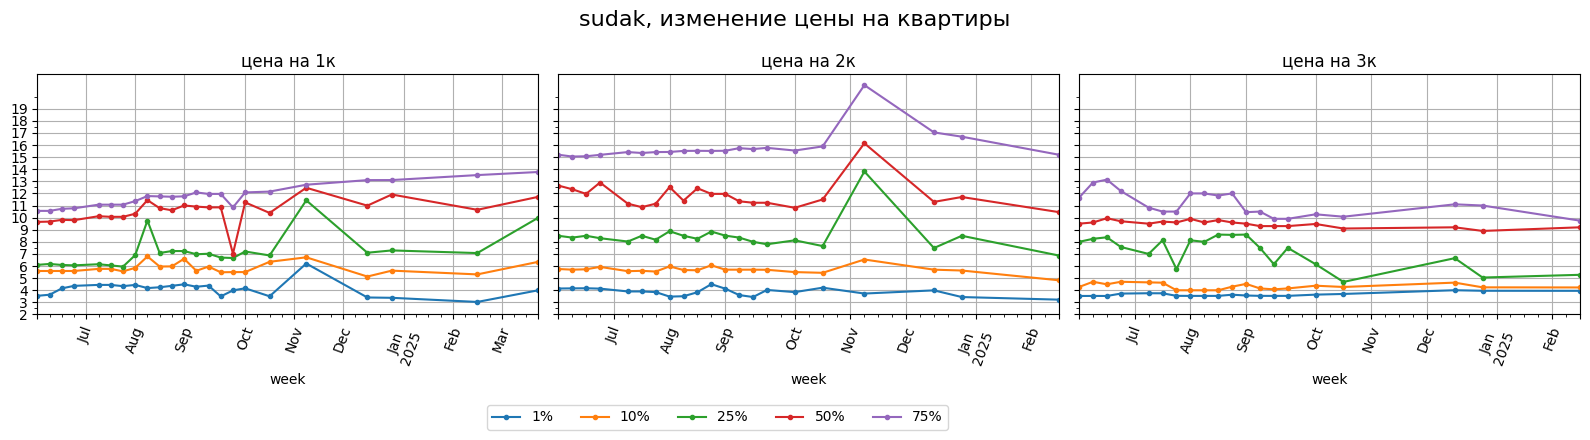

In [43]:
# history_date

place = 'sudak'

# fig, ax = plt.subplots(len(sizes),1,figsize=(11,4*len(sizes)), sharey=True )
fig, ax = plt.subplots(1,len(sizes),figsize=(16,4), sharey=True )
for i,s in enumerate(sizes): 
    stat_.loc[(s),cols].plot(title=f'цена на {s}к', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   
    # stat.loc[(place,s),cols].plot(title=f'цена на {s}к', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   
    ax[i].set_yticks( np.arange(2, 20, step=1) )

fig.suptitle(f'{place}, изменение цены на квартиры', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

In [44]:
fig, ax = plt.subplots(1,len(sizes),figsize=(11,4), sharey=True )

for i,s in enumerate(sizes): 
    stat_.loc[s,'count'].plot(title=f'предложений {s}к', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   
    # stat.loc[(place,s),'count'].plot(title=f'предложений {s}к', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place},изменение количества предложений на квартиры', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

# актуальная цена

In [45]:
# sorted(gdf['dt'].unique() )

In [46]:
# dt_now = pd.to_datetime('2024-06-17').date()
dt_now = gdf['dt'].max()
display(len(gdf))
gdf_last = gdf[ gdf['dt'] == dt_now ]
display(len(gdf_last))

67738

1511

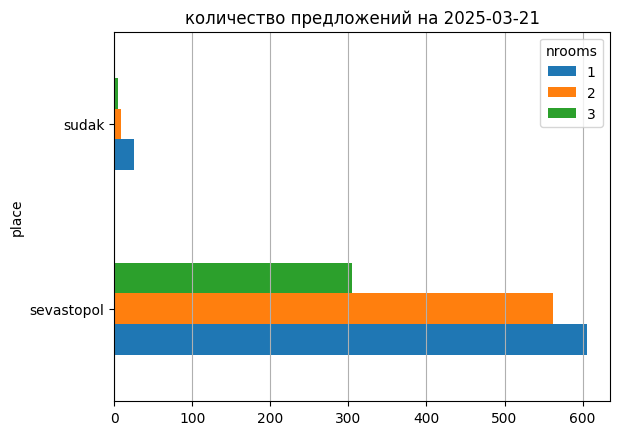

In [47]:
(
gdf_last
.drop_duplicates('url')
.groupby(['nrooms','place'])['url'].count().reset_index()
.pivot(index='place', columns='nrooms', values='url')
.plot.barh(title='количество предложений на '+ str(dt_now))
.grid(axis='x')    
)

In [48]:
(
    gdf_last
    .drop_duplicates('url')
    .groupby(['place','nrooms'])
    ['priceM'].describe(percentiles=percentiles)
)

count  mean  std  min   1%   5%  10%   25%   50%   75%  \
place      nrooms                                                           
sevastopol 1      605.00  6.96 2.09 2.00 3.70 4.52 4.99  5.42  6.45  8.15   
           2      562.00  9.28 3.26 2.95 4.89 5.80 6.20  7.20  8.30 10.67   
           3      304.00 12.81 6.88 2.70 5.40 7.10 7.90  8.70 10.95 15.00   
sudak      1       26.00 11.26 3.26 4.00 4.00 4.42 6.35 10.00 11.72 13.77   
           2        9.00 13.62 7.43 6.00 6.00 6.00 6.00  6.80 12.00 15.80   
           3        5.00 12.21 6.47 7.60 7.63 7.74 7.88  8.30  9.00 13.00   

                    90%   95%   max  
place      nrooms                    
sevastopol 1       9.70 10.80 19.99  
           2      13.99 15.39 29.00  
           3      21.00 22.50 85.00  
sudak      1      14.81 15.26 15.39  
           2      24.19 25.37 26.54  
           3      19.09 21.12 23.16

In [49]:
q_95 = gdf_last.groupby(['place'])['priceM'].quantile(.95)

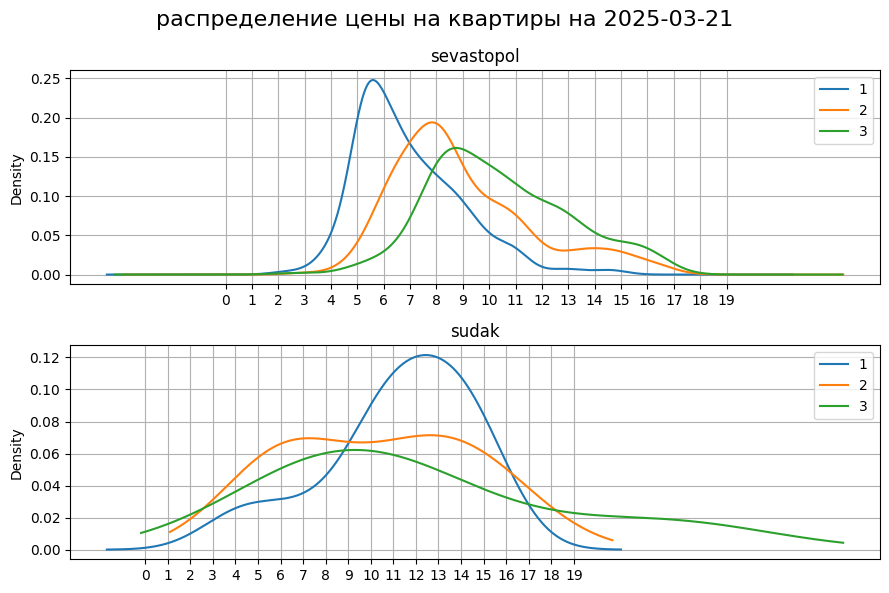

In [50]:
places = ['sevastopol','sudak',]
fig, ax = plt.subplots(len(places),1,figsize=(9,6)) #, sharex=True )
for i,p in enumerate(places): 
    (
        gdf_last
        .drop_duplicates('url')
        .query(f'(place=="{p}")&(priceM<{q_95[p]})')
        .groupby(['nrooms'],observed=True)
        ['priceM'].plot.kde(legend=True,ax=ax[i],title=f'{p}', grid=True)   
    )
    ax[i].set_xticks( np.arange(0, 20, step=1) )
fig.suptitle(f'распределение цены на квартиры на '+ str( gdf_last['dt'].max() ), fontsize=16)
fig.tight_layout()

In [ ]:
# import seaborn as sns
# _, [axs_hist, axs_box] = plt.subplots(2, 1, figsize=(15, 7),
#                                       sharex=True,
#                                       gridspec_kw=dict(height_ratios=[10,1]))

# ap_hist = sns.histplot(data=data_arc, x='Реактивная мощность', kde=True, ax=axs_hist)
# ap_hist.set_ylabel('Количество строк')
# ap_hist.set_title('Гистограмма распределения реактивной мощности')

# ap_box = sns.boxplot(data=data_arc, x='Реактивная мощность', ax=axs_box) 
# ap_box.set_xlabel('Реактивная мощность')

In [ ]:
# places = ['sevastopol','sudak',]
# fig, ax = plt.subplots(len(places),1,figsize=(9,6)) #, sharex=True )
# for i,p in enumerate(places): 
#      # sns.histplot(data=data_arc, x='Реактивная мощность', kde=True, ax=axs_hist)
#     (
#         gdf_last
#         .drop_duplicates('url')
#         .query(f'(place=="{p}")&(priceM<{q_95[p]})')
#         .groupby(['nrooms'],observed=True)
#         ['priceM'].plot.kde(legend=True,ax=ax[i],title=f'{p}', grid=True)   
#     )
#     ax[i].set_xticks( np.arange(0, 20, step=1) )

# fig.suptitle(f'распределение цены на квартиры на '+ str( gdf_last['dt'].max() ), fontsize=16)
# fig.tight_layout()

In [51]:
# p = 'sudak'
p = 'sevastopol'
fig, ax = plt.subplots(4,1,figsize=(12,5), sharex=True, gridspec_kw={'height_ratios': [7,1,1,1]})
(
    gdf_last
    .drop_duplicates('url')
    .query(f'(place=="{p}")&(priceM<{q_95[p]})')
    .groupby(['nrooms'],observed=True)
    ['priceM'].plot.kde(legend=True,title=f'{p}', grid=True, ax=ax[0])
    # ['priceM'].plot.hist(legend=True,title=f'{p}', grid=True, ax=ax[0],bins=30)
)
ax[0].set_xticks( np.arange(0, 20, step=1) )

for n in range(1,4):
    (
        gdf_last    
        .query(f'(place=="{p}")&(priceM<{q_95[p]})&(nrooms=={n})')
        ['priceM'].plot.box(grid=True, vert=False, ax=ax[n], label=f'{n}')
    )
    ax[n].grid( axis='y')

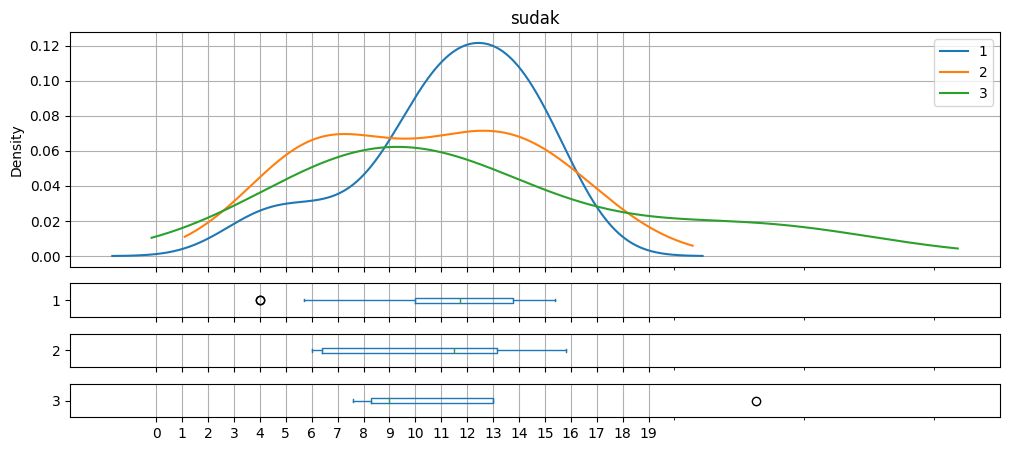

In [52]:
p = 'sudak'
# p = 'sevastopol'
fig, ax = plt.subplots(4,1,figsize=(12,5), sharex=True, gridspec_kw={'height_ratios': [7,1,1,1]})
(
    gdf_last
    .drop_duplicates('url')
    .query(f'(place=="{p}")&(priceM<{q_95[p]})')
    .groupby(['nrooms'],observed=True)
    ['priceM'].plot.kde(legend=True,title=f'{p}', grid=True, ax=ax[0])
    # ['priceM'].plot.hist(legend=True,title=f'{p}', grid=True, ax=ax[0],bins=30)
)
ax[0].set_xticks( np.arange(0, 20, step=1) )

for n in range(1,4):
    (
        gdf_last    
        .query(f'(place=="{p}")&(priceM<{q_95[p]})&(nrooms=={n})')
        ['priceM'].plot.box(grid=True, vert=False, ax=ax[n], label=f'{n}')
    )
    ax[n].grid( axis='y')

# цены на карте

In [53]:
# !pip install polyfill

In [54]:
import h3
from shapely.geometry import Polygon
from shapely.geometry import MultiPoint

In [55]:
# def cover_grid_hexagonal(gmtr,cell_size=6,crs='EPSG:4326'):
#     polygonise = lambda hex_id: Polygon( h3.h3_to_geo_boundary( hex_id, geo_json=True)  )
#     hexs = list(h3.polyfill( gmtr.__geo_interface__, cell_size, geo_json_conformant = True ))
#     return gpd.GeoDataFrame({ 'hex_id': hexs,  'geometry': list(map(polygonise, hexs)), },crs=crs,)

## Севастополь

In [56]:
# frame_sevastopol = gpd.GeoDataFrame([{ # все предложения
#             'place':'sevastopol', 
#             'geometry':MultiPoint( gdf_last.query('place=="sevastopol"')['geometry'].tolist() ).convex_hull, 
#         }],crs='EPSG:4326')

# # frame_sevastopol.explore()

In [57]:
# grid = cover_grid_hexagonal( frame_sevastopol.geometry.values[0],cell_size=7 )

In [58]:
# gdf_last.columns #[['']]

In [59]:
# # медиана цены за квадратный метр (тыс.руб.)

# grid_values = ( 
#     grid
#     .sjoin( gdf_last.drop_duplicates('url').query('place=="sevastopol"'), how='inner',)
#     .groupby(['hex_id'])
#     ['price_area_K']
#     .median()
#     .reset_index()
# )
# grid.merge(grid_values,on='hex_id').explore('price_area_K',cmap='rainbow') #'area_name', legend=True)

## Судак

In [60]:
# frame_sudak = gpd.GeoDataFrame([{ # все предложения
#             'place':'sudak', 
#             'geometry':MultiPoint( gdf_last.query('place=="sudak"')['geometry'].tolist() ).convex_hull, 
#         }],crs='EPSG:4326')

# # frame_sudak.explore()

In [61]:
# grid = cover_grid_hexagonal( frame_sudak.geometry.values[0],cell_size=9 )

In [62]:
# # медиана цены за квадратный метр (тыс.руб.)
# grid_values = ( 
#     grid
#     .sjoin( 
#         gdf_last
#         .drop_duplicates('url')
#         .query('place=="sudak"'), how='inner',)
#     .groupby(['hex_id'])
#     ['price_area_K']
#     .median()
#     .reset_index()
# )
# grid.merge(grid_values,on='hex_id').explore('price_area_K',cmap='rainbow') #'area_name', legend=True)

# районы Севастополя

In [63]:
# загружаем области поиска
frames_path = 'data/frames/'
frames_index = pd.read_csv(f'{frames_path}/_index.tsv',sep='\t')

swap_coo = lambda coo : [ (c[1],c[0]) for c in coo ]
df2poly = lambda df : Polygon(swap_coo(df.values))

frames = gpd.GeoDataFrame([ 
        { 'area_name':nm, 'geometry': df2poly( pd.read_csv(f'{frames_path}/{f}',header=None) ) } 
        for nm,f in frames_index.values
    ],crs='epsg:4326',)

# display(frames)

In [64]:
display(frames[['area_name']])

area_name
0     Севастополь, район Острякова
1  Севастополь, парк 60-летия СССР
2  Севастополь, Хрусталёва/Хрюкина
3  Севастополь, Геловани/Коломийца
4     Севастополь, Музыки/Бирюзова
5   Севастополь, кр.горка (старый)
6    Севастополь, кр.горка (новый)
7      Севастополь, Малахов курган
8       Севастополь, Благополучный

In [65]:
frames.explore('area_name', legend=True)

In [66]:
area_name=[
#'Севастополь, парк 60-летия СССР',
#'Севастополь, Хрусталёва/Хрюкина',
'Севастополь, район Острякова',
#'Севастополь, Малахов курган',
#'Севастополь, Геловани/Коломийца',
]

In [67]:
# выбираем область
frame_ = frames[frames['area_name'].isin(area_name)]

In [68]:
# фильтруем данные по области
gdf_last_local = gdf_last.drop_duplicates('url').sjoin( frame_, how='inner', predicate='within') 
gdf_last_local[['title','priceM','address','geometry']].explore( legend=False)

In [69]:
(
    gdf_last_local
    .drop_duplicates('url')
    .groupby(['nrooms'])['url'].count()
    .plot.barh(title='количество предложений на '+ str( dt_now ) + '\n' + ' / '.join(area_name) )
    .grid(axis='x')
)

In [70]:
(
    gdf_last_local
    .drop_duplicates('url')
    .groupby(['nrooms'])['priceM']
    .describe(percentiles=percentiles)
)

count  mean  std  min   1%   5%  10%  25%  50%   75%   90%   95%   max
nrooms                                                                        
1       75.00  6.17 1.16 3.90 4.12 4.71 4.90 5.35 6.10  6.75  7.68  8.05 10.30
2       85.00  8.33 2.33 5.60 5.68 6.00 6.30 6.80 7.80  8.90 11.00 12.68 18.70
3       37.00  9.90 2.52 5.50 6.04 7.24 7.61 8.30 9.67 10.50 12.88 15.70 17.90

In [71]:
# q_95 = gdf_last_local['priceM'].quantile(.95)

# fig, ax = plt.subplots(figsize=(7,3) )
# (
#     gdf_last_local
#     .query(f'(priceM<{q_95})')
#     .drop_duplicates('url')
#     .groupby(['nrooms'],observed=True)
#     ['priceM'].plot.kde(legend=True,ax=ax,title='/'.join(area_name), grid=True)   
# )

# ax.set_xticks( np.arange(2, 16, step=1) )

# fig.suptitle(f'распределение цены на квартиры на '+ str( dt_now ), fontsize=16)
# fig.tight_layout()

In [72]:
# p = 'sudak'
p = 'sevastopol'
fig, ax = plt.subplots(4,1,figsize=(9,5), sharex=True, gridspec_kw={'height_ratios': [7,1,1,1]})
(
    gdf_last_local
    .drop_duplicates('url')
    .query(f'(priceM<{q_95[p]})')
    .groupby(['nrooms'],observed=True)
    ['priceM'].plot.kde(legend=True, grid=True, ax=ax[0],title='/'.join(area_name))
    # ['priceM'].plot.hist(legend=True,title=f'{p}', grid=True, ax=ax[0],bins=30)
)
ax[0].set_xticks( np.arange(2, 20, step=1) )

for n in range(1,4):
    (
        gdf_last_local    
        .query(f'(priceM<{q_95[p]})&(nrooms=={n})')
        ['priceM'].plot.box(grid=True, vert=False, ax=ax[n], label=f'{n}')
    )
    ax[n].grid( axis='y')

fig.suptitle(f'распределение цены на квартиры на '+ str( dt_now ), fontsize=16)
fig.tight_layout()

----

In [73]:
# изменение цены по району
gdf_local = gdf.sjoin( frame_, how='inner', predicate='within') 

In [74]:
percentiles=[.01,.05,.1,.25,.5,.75,.9]
# stat = gdf_local.groupby(['nrooms','month'],observed=True)['priceM'].describe(percentiles=percentiles)
stat = gdf_local.groupby(['nrooms','week'],observed=True)['priceM'].describe(percentiles=percentiles)
# display( stat )

In [75]:
w_now = gdf_local['week'].max()
display(w_now)
(
    gdf_local[ gdf_local['week'] == w_now ]
    .groupby(['nrooms'],observed=True)
    ['priceM'].describe(percentiles=percentiles)
)

Period('2025-03-17/2025-03-23', 'W-SUN')

count  mean  std  min   1%   5%  10%  25%  50%   75%   90%   max
nrooms                                                                  
1       75.00  6.17 1.16 3.90 4.12 4.71 4.90 5.35 6.10  6.75  7.68 10.30
2       85.00  8.33 2.33 5.60 5.68 6.00 6.30 6.80 7.80  8.90 11.00 18.70
3       37.00  9.90 2.52 5.50 6.04 7.24 7.61 8.30 9.67 10.50 12.88 17.90

In [76]:
# display( stat )

In [77]:
# # history_date

# place = 'sevastopol'

# fig, ax = plt.subplots(len(sizes),1,figsize=(11,4*len(sizes)), sharey=True )

# for i,s in enumerate(sizes): 
#     stat.loc[(place,s),cols].plot(title=f'цена на {s}к', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   
#     ax[i].set_yticks( np.arange(2, 16, step=1) )

# fig.suptitle(f'{place}, изменение цены на квартиры', fontsize=16)
# fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
# fig.tight_layout()

In [78]:
# fig, ax = plt.subplots(len(sizes),1,figsize=(11,4*len(sizes)), sharey=True )
fig, ax = plt.subplots(1,len(sizes),figsize=(16,4), sharey=True )
for i,s in enumerate(sizes): 
    stat.loc[(s),cols].plot(title=f'цена {s}к', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   
    ax[i].set_yticks( np.arange(3, 12, step=1) )

fig.suptitle(f'изменение цены на квартиры\n {'/'.join(area_name)}', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

In [79]:
fig, ax = plt.subplots(1,len(sizes),figsize=(11,4), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(s),'count'].plot(title=f'предложений {s}к', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'изменение количества предложений на квартиры\n {'/'.join(area_name)}', fontsize=16)

fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()